## This notebook implements a streaming architecture:

Producer: Fetches live data from OpenSky and publishes it to a Google Cloud Pub/Sub Topic.

Consumer: Pulls messages from the Pub/Sub Subscription, streams them into a new BigQuery table (realtime_flight_data), and immediately runs predictions using your existing BQML models.

## 1. Setup and Authentication

Context: Installs necessary Google Cloud libraries and handles Colab authentication.

Prompt: "Write a Python code block for Google Colab that performs the following:

Installs the google-cloud-pubsub, google-cloud-bigquery, google-cloud-storage, and requests libraries via pip.

Imports auth from google.colab and authenticates the user to the Google Cloud environment."

In [ ]:
# Install required packages
# !pip install google-cloud-pubsub google-cloud-bigquery google-cloud-storage requests

from google.colab import auth
print("Authenticating to Google Cloud...")
auth.authenticate_user()
print("Authentication successful.")

Authenticating to Google Cloud...
Authentication successful.


## Cell 2: Configuration Variables

Context: Defines global variables for Project ID, Pub/Sub resources, and BigQuery resources.

Prompt: "Create a configuration cell that defines Python variables for a Google Cloud project. Specifically, define:

PROJECT_ID (e.g., 'mgmt-467-47888')

REGION (e.g., 'us-central1')

TOPIC_NAME (e.g., 'opensky-realtime-topic')

SUBSCRIPTION_NAME (e.g., 'opensky-realtime-sub')

BQ_DATASET (e.g., 'training_dataset')

BQ_TABLE_REALTIME (e.g., 'realtime_flight_data')

MODEL_NAME (e.g., 'flight_velocity_predictor')

Finally, execute a shell command to set the gcloud config project to the defined PROJECT_ID."

In [ ]:
# --- Configuration ---
PROJECT_ID = "noble-broker-471012-q6"
REGION = "us-central1"

# Pub/Sub Configuration
TOPIC_NAME ="opensub-realtime-topic2"
SUBSCRIPTION_NAME = "opensky-realtime-sub2"

# BigQuery Configuration
BQ_DATASET = "lab8"
BQ_TABLE_REALTIME = "data2" # New table for streaming data
MODEL_NAME = "flight_velocity_predictor"   # The model we made in Unit 3.2

# Set the project for gcloud commands
!gcloud config set project $PROJECT_ID

INFORMATION: Project 'noble-broker-471012-q6' has no 'environment' tag set. Use either 'Production', 'Development', 'Test', or 'Staging'. Add an 'environment' tag using `gcloud resource-manager tags bindings create`.
Updated property [core/project].


## Cell 3: Infrastructure Setup (Idempotent)

In [ ]:
# Install required packages
!pip install google-cloud-pubsub google-cloud-bigquery google-cloud-storage requests

In [ ]:
from google.cloud import pubsub_v1, bigquery
from google.api_core.exceptions import NotFound, AlreadyExists

# Initialize clients
publisher_client = pubsub_v1.PublisherClient()
subscriber_client = pubsub_v1.SubscriberClient()
bq_client = bigquery.Client()

# Construct full resource paths
topic_path = publisher_client.topic_path(PROJECT_ID, TOPIC_NAME)
subscription_path = subscriber_client.subscription_path(PROJECT_ID, SUBSCRIPTION_NAME)

# 1. Create Pub/Sub Topic if it doesn't exist
print(f"Checking Pub/Sub Topic: {TOPIC_NAME}...")
try:
    publisher_client.get_topic(request={"topic": topic_path})
    print(f"Topic {TOPIC_NAME} already exists.")
except NotFound:
    try:
        publisher_client.create_topic(request={"name": topic_path})
        print(f"Topic {TOPIC_NAME} created.")
    except AlreadyExists:
        print(f"Topic {TOPIC_NAME} already exists (concurrent creation).")

# 2. Create Pub/Sub Subscription if it doesn't exist
print(f"Checking Pub/Sub Subscription: {SUBSCRIPTION_NAME}...")
try:
    subscriber_client.get_subscription(request={"subscription": subscription_path})
    print(f"Subscription {SUBSCRIPTION_NAME} already exists.")
except NotFound:
    try:
        # The topic must exist before creating a subscription to it
        subscriber_client.create_subscription(
            request={"name": subscription_path, "topic": topic_path}
        )
        print(f"Subscription {SUBSCRIPTION_NAME} created.")
    except AlreadyExists:
        print(f"Subscription {SUBSCRIPTION_NAME} already exists (concurrent creation).")

# 3. Create BigQuery Dataset if it doesn't exist
dataset_id = f"{PROJECT_ID}.{BQ_DATASET}"
dataset = bigquery.Dataset(dataset_id)

print(f"Checking BigQuery Dataset: {BQ_DATASET}...")
try:
    bq_client.get_dataset(dataset_id)
    print(f"Dataset {BQ_DATASET} already exists.")
except NotFound:
    try:
        dataset = bq_client.create_dataset(dataset)
        print(f"Dataset {BQ_DATASET} created.")
    except AlreadyExists:
        print(f"Dataset {BQ_DATASET} already exists (concurrent creation).")

# 4. Create BigQuery Table if it doesn't exist
table_id = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}"

# Define the schema for the realtime_flight_data table
schema = [
    bigquery.SchemaField("icao24", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("callsign", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("origin_country", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("time_position", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("last_contact", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("longitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("latitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("baro_altitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("geo_altitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("on_ground", "BOOLEAN", mode="NULLABLE"),
    bigquery.SchemaField("velocity", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("heading", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("vertical_rate", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("squawk", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("spi", "BOOLEAN", mode="NULLABLE"),
    bigquery.SchemaField("position_source", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("sensor_timestamp", "TIMESTAMP", mode="NULLABLE"), # Timestamp for when the data was processed
]

table = bigquery.Table(table_id, schema=schema)

print(f"Checking BigQuery Table: {BQ_TABLE_REALTIME}...")
try:
    bq_client.get_table(table_id)
    print(f"Table {BQ_TABLE_REALTIME} already exists.")
except NotFound:
    try:
        table = bq_client.create_table(table)
        print(f"Table {BQ_TABLE_REALTIME} created.")
    except AlreadyExists:
        print(f"Table {BQ_TABLE_REALTIME} already exists (concurrent creation).")

print("All required Google Cloud resources are ready.")

Checking Pub/Sub Topic: opensub-realtime-topic2...
Topic opensub-realtime-topic2 created.
Checking Pub/Sub Subscription: opensky-realtime-sub2...
Subscription opensky-realtime-sub2 created.
Checking BigQuery Dataset: lab8...
Dataset lab8 already exists.
Checking BigQuery Table: data2...
Table data2 created.
All required Google Cloud resources are ready.


Context: Uses Python clients to create the Topic, Subscription, Dataset, and Table if they don't already exist.

Prompt: "Write a Python script using the Google Cloud SDK (google.cloud) to set up infrastructure idempotently. The script should:

Initialize Pub/Sub and BigQuery clients.

Create a Pub/Sub Topic if it doesn't exist.

Create a Pub/Sub Subscription to that topic if it doesn't exist.

Create a BigQuery Dataset if it doesn't exist.

Create a BigQuery Table named realtime_flight_data if it doesn't exist.

Use a schema for the table that includes fields for OpenSky data: icao24 (STRING), callsign (STRING), origin_country (STRING), time_position (INTEGER), longitude (FLOAT), latitude (FLOAT), geo_altitude (FLOAT), on_ground (BOOLEAN), velocity (FLOAT), heading (FLOAT), vertical_rate (FLOAT), and sensor_timestamp (TIMESTAMP). Handle AlreadyExists exceptions gracefully."

## Cell 4: OpenSky API Class Helper

Context: A helper class to interact with the REST API.

Prompt: "Write a Python class named OpenSkyApi. The constructor should accept a username and password. Include a method named get_states that accepts bounding box coordinates (lmin, lmax, hmin, hmax) or an icao24 code. The method should make a GET request to https://opensky-network.org/api/states/all and return the list of flight states from the JSON response."

In [ ]:
import requests
from collections import defaultdict

OPEN_SKY_USERNAME = "none"
OPEN_SKY_PASSWORD = "none"

class OpenSkyApi(object):
    def __init__(self, username, password):
        self._auth = (username, password)
        self._api_url = "https://opensky-network.org/api"
        self._last_requests = defaultdict(lambda: 0)

    def get_states(self, icao24=None, time_sec=None, lmin=None, lmax=None, hmin=None, hmax=None):
        params = {}
        if icao24:
            params['icao24'] = icao24
        if time_sec:
            params['time'] = time_sec
        if lmin is not None:
            params['lamin'] = lmin
        if lmax is not None:
            params['lamax'] = lmax
        if hmin is not None:
            params['lomin'] = hmin
        if hmax is not None:
            params['lomax'] = hmax

        try:
            response = requests.get(f"{self._api_url}/states/all",
                                    params=params,
                                    auth=self._auth)
            response.raise_for_status()
            data = response.json()
            return data.get('states', [])
        except requests.exceptions.RequestException as e:
            print(f"Error fetching OpenSky data: {e}")
            return []

## 5. Data Processing and Publishing Function

Context: Parses API data, cleans it, and pushes JSON messages to Pub/Sub.

Prompt: "Create a function named process_and_publish that takes an OpenSky API response, a Pub/Sub publisher client, and a topic path.

The function should:

Iterate through the flight states.

Map the raw list data to a dictionary with keys matching a BigQuery schema (icao24, callsign, longitude, latitude, velocity, geo_altitude, etc.).

Add a current UTC timestamp field named sensor_timestamp.

Filter out any records where velocity or geo_altitude are None.

Publish the valid records as JSON strings to the Pub/Sub topic.

Return the count of published messages."

In [ ]:
import json
import datetime
from google.cloud import pubsub_v1

publisher_client = pubsub_v1.PublisherClient() # Re-initialize client if not globally available after split

def process_and_publish(api_response, publisher_client, topic_path):
    """Parses API response and publishes each flight as a Pub/Sub message, then cleans and filters."""
    if not api_response or 'states' not in api_response or api_response['states'] is None:
        print("No flight data received from OpenSky API.")
        return 0

    published_count = 0
    current_utc_timestamp = datetime.datetime.utcnow().isoformat() + "Z"

    for state_vector in api_response['states']:
        data = {
            "icao24": state_vector[0],
            "callsign": state_vector[1].strip() if state_vector[1] else None,
            "origin_country": state_vector[2].strip() if state_vector[2] else None,
            "time_position": state_vector[3],
            "last_contact": state_vector[4],
            "longitude": state_vector[5],
            "latitude": state_vector[6],
            "baro_altitude": state_vector[7],
            "geo_altitude": state_vector[13],
            "on_ground": state_vector[8],
            "velocity": state_vector[9],
            "heading": state_vector[10],
            "vertical_rate": state_vector[11],
            "squawk": state_vector[14] if len(state_vector) > 14 else None,
            "spi": state_vector[15] if len(state_vector) > 15 else None,
            "position_source": state_vector[16] if len(state_vector) > 16 else None,
            "sensor_timestamp": current_utc_timestamp,
        }

        if data['velocity'] is not None and data['geo_altitude'] is not None:
            message_json_string = json.dumps(data)
            message_bytes = message_json_string.encode("utf-8")
            future = publisher_client.publish(topic_path, message_bytes)
            published_count += 1
        else:
            print(f"Skipping record due to missing velocity or geo_altitude for icao24: {state_vector[0]}")
    return published_count

## 6. Subscriber and Prediction Function
Context: Pulls messages, inserts to BQ, and runs an ML.PREDICT query immediately.

Prompt: "Write a function named pull_and_insert_and_predict that runs for a specified timeout period.

Inside the function:

Subscribe to the Pub/Sub subscription.

When a message is received, parse the JSON data.

Insert the row immediately into the BigQuery table realtime_flight_data.

Upon successful insertion, run a BigQuery SQL query using ML.PREDICT with the model flight_velocity_predictor. The query should predict the velocity for the specific flight (identified by icao24 and sensor_timestamp) that was just inserted.

Print the prediction results and acknowledge the Pub/Sub message."

In [ ]:
import google.cloud.pubsub_v1 as pubsub_v1_module
import google.cloud.bigquery as bigquery_module
from concurrent.futures import TimeoutError
import pandas as pd # Import pandas for DataFrame conversion

subscriber_client = pubsub_v1_module.SubscriberClient() # Re-initialize client if not globally available after split
bq_client = bigquery_module.Client(project=PROJECT_ID) # Explicitly pass PROJECT_ID here

# Define resource paths/IDs within this cell for reliability
subscription_path = subscriber_client.subscription_path(PROJECT_ID, SUBSCRIPTION_NAME)
table_id = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}"

def pull_and_insert_and_predict(timeout=60):
    """Pulls messages from Pub/Sub, inserts into BigQuery, and runs BQML prediction.
    Returns a list of prediction results.
    """
    all_predictions = [] # List to store all prediction results

    def callback(message):
        print(f"Received message: {message.data.decode('utf-8')}")
        try:
            data_json = json.loads(message.data.decode('utf-8'))

            rows_to_insert = [data_json]
            errors = bq_client.insert_rows_json(table_id, rows_to_insert)

            if errors:
                print(f"Errors occurred during BigQuery insert: {errors}")
            else:
                print(f"Successfully inserted row for icao24={data_json.get('icao24')} into {table_id}")

                predict_query = f"""
                SELECT
                    *
                FROM
                    ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{MODEL_NAME}`,
                        (SELECT
                            geo_altitude AS altitude, # Alias geo_altitude to altitude
                            vertical_rate,
                            heading
                         FROM
                            `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}`
                         WHERE
                            icao24 = '{data_json['icao24']}'
                            AND sensor_timestamp = TIMESTAMP('{data_json['sensor_timestamp']}')
                         LIMIT 1))
                """
                predict_job = bq_client.query(predict_query)
                prediction_results = predict_job.result()

                for row in prediction_results:
                    prediction_dict = dict(row.items()) # Convert Row object to dictionary
                    all_predictions.append(prediction_dict) # Store the prediction result
                    print(f"BQML Prediction for icao24 {data_json['icao24']}: {prediction_dict}")
        except Exception as e:
            print(f"Error processing message or during BQML prediction: {e}")
        finally:
            message.ack()

    streaming_pull_future = subscriber_client.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}... (Timeout: {timeout} seconds)\n")

    try:
        streaming_pull_future.result(timeout=timeout)
    except TimeoutError:
        streaming_pull_future.cancel()
        streaming_pull_future.result()
        print("Listening timed out. No messages received within the specified duration.")
    except Exception as e:
        print(f"An error occurred during streaming pull: {e}")
        streaming_pull_future.cancel()
        streaming_pull_future.result()

    return all_predictions

## 7. Main Execution (Publisher Loop)

Context: Fetches live data and calls the publish function.

Prompt: "Write a script to execute the pipeline.

Initialize the OpenSkyApi client (using placeholder credentials if necessary).

Call the API to get flight states for a bounding box around Los Angeles (approx lat 34.0 to 34.5, lon -118.5 to -118.0).

Initialize the Pub/Sub publisher client.

Call the process_and_publish function to send the data to Pub/Sub.

Print the number of messages successfully published."

In [ ]:
print("Fetching flight data from OpenSky and publishing to Pub/Sub...")

# Ensure configuration variables are accessible
# TOPIC_ID, PROJECT_ID, OPEN_SKY_USERNAME, OPEN_SKY_PASSWORD are expected to be defined globally
#TOPIC_NAME = TOPIC_ID # Aligning with how other functions expect TOPIC_NAME

# Initialize OpenSky API client
opensky_api = OpenSkyApi(OPEN_SKY_USERNAME, OPEN_SKY_PASSWORD)

# Fetch states for a specific region (e.g., around a major airport)
# Adjust these coordinates as needed for your desired coverage area
lmin = 34.0
lmax = 34.5
hmin = -118.5
hmax = -118.0

states = opensky_api.get_states(lmin=lmin, lmax=lmax, hmin=hmin, hmax=hmax)

if states:
    # Initialize publisher client (if not already done globally)
    publisher_client = pubsub_v1.PublisherClient()

    # Topic path is already defined from configuration cell
    topic_path = publisher_client.topic_path(PROJECT_ID, TOPIC_NAME) # Using the now-defined TOPIC_NAME

    published_count = process_and_publish({'states': states}, publisher_client, topic_path)
    print(f"Successfully published {published_count} messages to Pub/Sub topic {TOPIC_NAME}.")
else:
    print("No states received from OpenSky API or an error occurred. No messages published.")

Fetching flight data from OpenSky and publishing to Pub/Sub...
Skipping record due to missing velocity or geo_altitude for icao24: a26381
Skipping record due to missing velocity or geo_altitude for icao24: ab351f
Skipping record due to missing velocity or geo_altitude for icao24: acf1ac
Skipping record due to missing velocity or geo_altitude for icao24: a7e58a
Skipping record due to missing velocity or geo_altitude for icao24: a4835c
Successfully published 12 messages to Pub/Sub topic opensub-realtime-topic2.


/tmp/ipython-input-230726547.py:14: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_utc_timestamp = datetime.datetime.utcnow().isoformat() + "Z"


## 8. Main Execution (Subscriber/Predictor)

Context: Runs the subscriber to process the data sent in the previous step.

Prompt: "Write a code block to run the pull_and_insert_and_predict function with a timeout of 60 seconds. Capture the returned predictions into a Pandas DataFrame. If predictions exist, display the head of the DataFrame; otherwise, print that no messages were received."

In [ ]:
print("Starting to pull messages and generate predictions...")
# Run the pull_and_insert_and_predict function and get the results
predictions_list = pull_and_insert_and_predict(timeout=180) # You can adjust the timeout as needed

if predictions_list:
    predictions_df = pd.DataFrame(predictions_list)
    print("\nBQML Prediction Results (DataFrame Head):")
    display(predictions_df.head())
else:
    print("No predictions were generated or received within the timeout period.")

Starting to pull messages and generate predictions...
Listening for messages on projects/noble-broker-471012-q6/subscriptions/opensky-realtime-sub2... (Timeout: 180 seconds)

Received message: {"icao24": "ae277c", "callsign": "GH08", "origin_country": "United States", "time_position": 1763672391, "last_contact": 1763672391, "longitude": -118.2739, "latitude": 34.1105, "baro_altitude": 403.86, "geo_altitude": 396.24, "on_ground": false, "velocity": 49.41, "heading": 271.79, "vertical_rate": 0.33, "squawk": null, "spi": false, "position_source": 0, "sensor_timestamp": "2025-11-20T21:00:10.052559Z"}Received message: {"icao24": "a4b1ff", "callsign": "00000000", "origin_country": "United States", "time_position": 1763672391, "last_contact": 1763672391, "longitude": -118.4641, "latitude": 34.1096, "baro_altitude": 11567.16, "geo_altitude": 11689.08, "on_ground": false, "velocity": 246.59, "heading": 331.19, "vertical_rate": 0, "squawk": "4563", "spi": false, "position_source": 0, "sensor_tim

,predicted_velocity,altitude,vertical_rate,heading
0,96.625021,2407.92,0.00,264.69
1,72.136475,327.66,-0.98,195.95
2,227.870725,10721.34,0.65,148.73
3,226.911595,11689.08,0.00,331.19
4,149.371133,4922.52,7.15,55.82


## 9. Visualization (Predicted vs Actual)

Context: Scatter plot of the results.

Prompt: "Using matplotlib and seaborn, write code to visualize the prediction results stored in the predictions_df DataFrame. Create a scatter plot where the x-axis is 'heading' and the y-axis is 'predicted_velocity'. Color the points based on the predicted velocity using a 'viridis' palette."

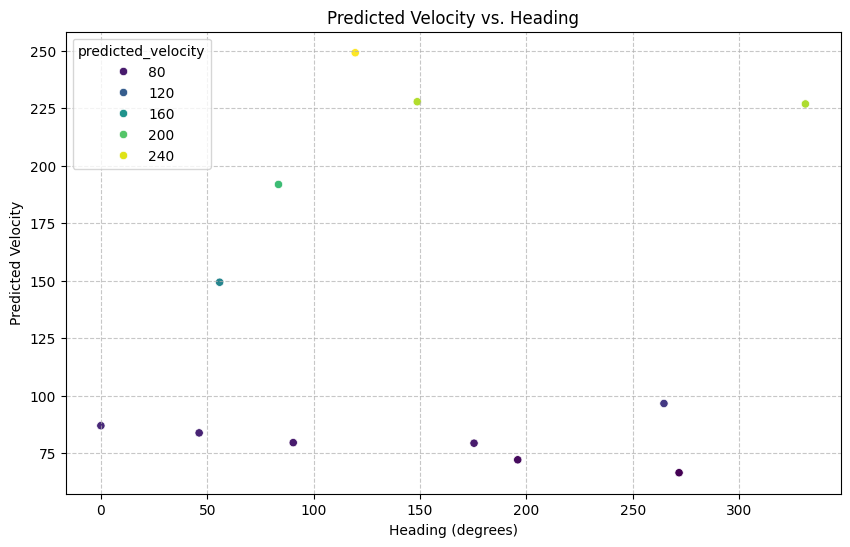

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'predictions_df' in locals() and not predictions_df.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='heading', y='predicted_velocity', data=predictions_df, hue='predicted_velocity', palette='viridis')
    plt.title('Predicted Velocity vs. Heading')
    plt.xlabel('Heading (degrees)')
    plt.ylabel('Predicted Velocity')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("predictions_df is not available or empty. Please ensure predictions are generated first.")

## 10. Flight Path Query & Visualization

Context: Queries historical data for a specific plane and plots the path.

Prompt: "Write a code block that:

Creates an input form field for CALLSIGN_TO_TRACK (defaulting to 'DAL339').

Queries the BigQuery table realtime_flight_data to retrieve the longitude, latitude, geo_altitude, and velocity for that callsign, ordered by timestamp.

Stores the result in a DataFrame.

Uses Seaborn to plot a line chart of Longitude vs. Latitude to visualize the flight path.

Mark the start position with a green dot and the end position with a red dot."

In [16]:
#@title Enter the Callsign to Track
CALLSIGN_TO_TRACK = 'N472LA' #@param {type:"string"}

print(f"You chose to track flight with Callsign: {CALLSIGN_TO_TRACK}")

You chose to track flight with Callsign: N472LA


In [17]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

print(f"Fetching flight data for callsign: {CALLSIGN_TO_TRACK}...")

flight_path_query = f"""
SELECT
    sensor_timestamp,
    longitude,
    latitude,
    geo_altitude,
    velocity,
    heading,
    vertical_rate
FROM
    `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}`
WHERE
    callsign = '{CALLSIGN_TO_TRACK}'
ORDER BY
    sensor_timestamp ASC
"""

flight_path_job = bq_client.query(flight_path_query)
flight_path_df = flight_path_job.to_dataframe()

if not flight_path_df.empty:
    print(f"Found {len(flight_path_df)} records for {CALLSIGN_TO_TRACK}.")
    display(flight_path_df.head())
else:
    print(f"No flight data found for callsign: {CALLSIGN_TO_TRACK}")

Fetching flight data for callsign: N472LA...
Found 1 records for N472LA.


,sensor_timestamp,longitude,latitude,geo_altitude,velocity,heading,vertical_rate
0,2025-11-20 21:00:10.052559+00:00,-118.2711,34.0741,327.66,37.45,195.95,-0.98


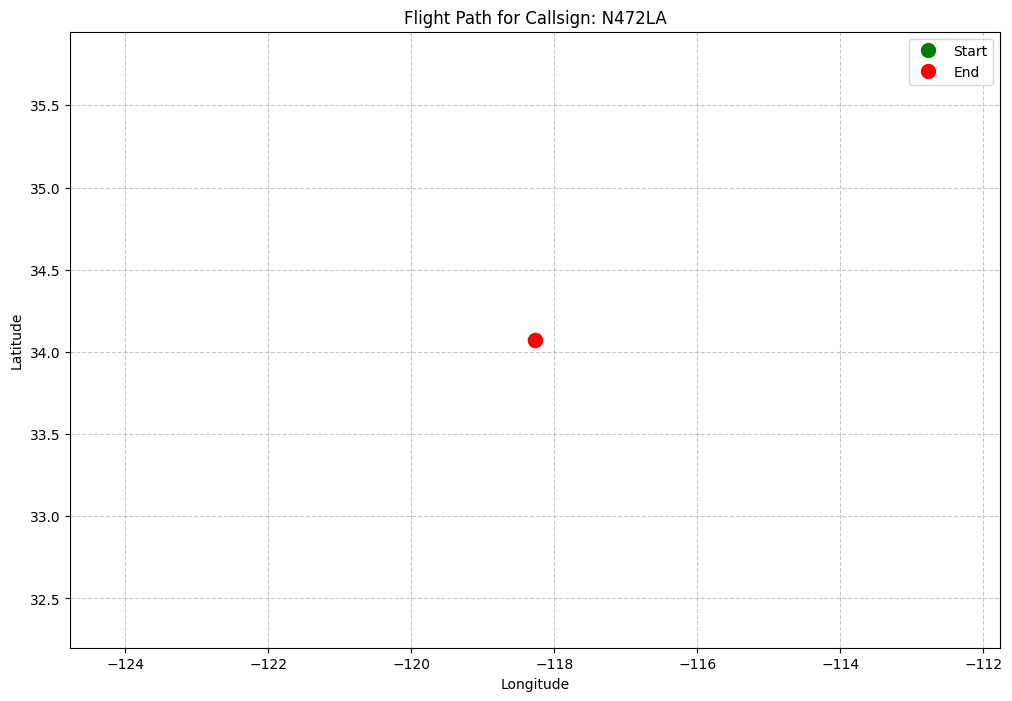

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'flight_path_df' in locals() and not flight_path_df.empty:
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='longitude', y='latitude', data=flight_path_df, marker='o', sort=False)
    plt.title(f'Flight Path for Callsign: {CALLSIGN_TO_TRACK}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, add start and end points
    if len(flight_path_df) > 0:
        plt.plot(flight_path_df['longitude'].iloc[0], flight_path_df['latitude'].iloc[0], 'go', markersize=10, label='Start') # Green circle for start
        plt.plot(flight_path_df['longitude'].iloc[-1], flight_path_df['latitude'].iloc[-1], 'ro', markersize=10, label='End') # Red circle for end

    plt.legend()
    plt.show()
else:
    print("No flight path data available to plot.")

## 11. Classification Model Prediction

Context: Using a different model to classify if a plane is on the ground.

Prompt: "Write a script to perform classification using BigQuery ML.

Define a model name flight_on_ground_classifier.

Construct a SQL query that uses ML.PREDICT with this model.

The input data for the prediction should be the most recent 100 records from the realtime_flight_data table (selecting icao24, geo_altitude, and velocity).

Execute the query and display the classification results in a DataFrame."

In [ ]:
# Define the classification model name
CLASSIFICATION_MODEL_NAME = "flight_on_ground_classifier"

print(f"Classification Model: {CLASSIFICATION_MODEL_NAME}")

Classification Model: flight_on_ground_classifier


In [ ]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

print(f"Running classification predictions using model: {CLASSIFICATION_MODEL_NAME}...")

# Construct the prediction query for the classification model
# We will use the latest data inserted into realtime_flight_data as input
classification_predict_query = f"""
SELECT
    * EXCEPT(predicted_on_ground_probs)
FROM
    ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{CLASSIFICATION_MODEL_NAME}`,
        (SELECT
            icao24,
            geo_altitude AS altitude, # Alias geo_altitude to altitude as required by model
            velocity
         FROM
            `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}`
         LIMIT 100 # Limit to avoid processing too much data for demonstration
         ))
"""

classification_predict_job = bq_client.query(classification_predict_query)
classification_predictions = classification_predict_job.result()

# Convert results to a Pandas DataFrame for easy viewing
classification_predictions_df = classification_predictions.to_dataframe()

if not classification_predictions_df.empty:
    print("\nBQML Classification Prediction Results (DataFrame Head):")
    display(classification_predictions_df.head())
else:
    print("No classification predictions were generated.")

Running classification predictions using model: flight_on_ground_classifier...

BQML Classification Prediction Results (DataFrame Head):


,predicted_on_ground,icao24,altitude,velocity
0,0,a0c1d7,670.56,57.80
1,0,a4b1ff,11689.08,246.59
2,0,ae277c,396.24,49.41
3,0,a299f9,266.70,34.93
4,1,aadf08,236.22,0.00
